# Priors
We will produce different distributions which will be further used to pose arbitrary priors on the latent variable of an Adversarial Autoencoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

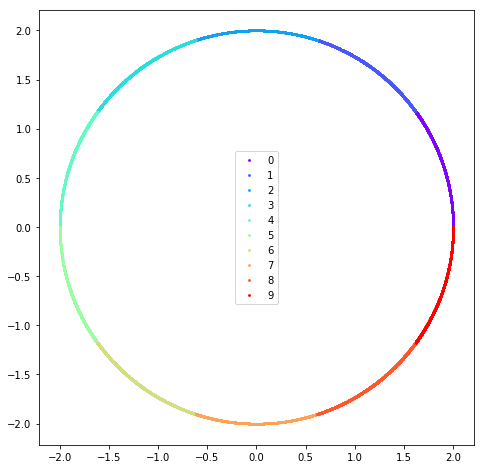

In [2]:
def plot_latent_variable(data, labels):
    if data.shape[1] != 2:
        pca = PCA(n_components=2)
        data = pca.fit_transform(data)
        print(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 8))
    plt.axes().set_aspect('equal')
    color = plt.cm.rainbow(np.linspace(0, 1, 10))
    for l, c in enumerate(color):
        idxs = np.where(labels==l)
        plt.scatter(data[idxs, 0], data[idxs, 1], c=c, label=l, linewidth=0, s=8)
    plt.legend()
    plt.show()
    
def uniform(batch_size, labels, n_labels=10):
    minv=-2; maxv=2
    num = int(np.ceil(np.sqrt(n_labels)))
    size = (maxv-minv)*1.0/num
    print(num, size)

    def sample(label):
        x, y = np.random.uniform(-size/2, size/2, (2,))
        i = label // num
        j = label % num
        x = x + j*size+minv+0.5*size
        y = y + i*size+minv+0.5*size
        return np.array([x, y]).reshape((2,))

    z = np.empty((batch_size, 2), dtype=np.float32)
    for idx in np.arange(batch_size):
        z[idx] = sample(labels[idx])
    return z

def swiss_roll(batch_size, labels, n_labels=10):
    def sample(label):
        rnd_num = np.random.uniform(0.0, 1.0) / n_labels + label / n_labels
        r = np.sqrt(rnd_num) * 3.0
        rad = np.pi * 4.0 * np.sqrt(rnd_num)
        x = r * np.cos(rad)
        y = r * np.sin(rad)
        return np.array([x, y]).reshape((2,))

    z = np.zeros((batch_size, 2), dtype=np.float32)
    for idx in np.arange(batch_size):
        z[idx] = sample(labels[idx])
    return z

def gaussian_mixture(batch_size, labels, n_labels=10):
    x_var=0.5; y_var=0.1
    def sample(x, y, label):
        shift = 1.4
        r = 2.0 * np.pi / float(n_labels) * float(label)
        new_x = x * np.cos(r) - y * np.sin(r)
        new_y = x * np.sin(r) + y * np.cos(r)
        new_x += shift * np.cos(r)
        new_y += shift * np.sin(r)
        return np.array([new_x, new_y]).reshape((2,))

    x = np.random.normal(0, x_var, (batch_size))
    y = np.random.normal(0, y_var, (batch_size))
    z = np.empty((batch_size, 2), dtype=np.float32)
    for idx in np.arange(batch_size):
        z[idx] = sample(x[idx], y[idx], labels[idx])
    return z

def gaussian(batch_size, n_dim):
    z = np.random.normal(0., 1., (batch_size, n_dim)).astype(np.float32)
    return z

def circle(batch_size, labels, n_labels=10):
    r = 2
    def sample(label):
        start = label*360./n_labels
        end = start + 360./n_labels
        rnd_deg = np.random.uniform(start, end)

        angle = np.deg2rad(rnd_deg)
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        return np.array([x, y]).reshape((2,))

    z = np.zeros((batch_size, 2), dtype=np.float32)
    for idx in np.arange(batch_size):
        z[idx] = sample(labels[idx])
    return z

class density_func():
    def __init__(self, batch_size, prior_type='uniform', n_dim=2, n_labels=10):
        self.batch_size = batch_size
        self.n_dim = n_dim
        self.n_labels = n_labels
        self.prior_type = prior_type

    def sample(self, labels = None):
        if labels is None: labels = np.random.randint(low = 0, high=self.n_labels, size=[self.batch_size])
        
        if self.prior_type == 'uniform':
            data =  uniform(self.batch_size, labels, n_labels=self.n_labels)
        elif self.prior_type == 'swiss_roll':
            data = swiss_roll(self.batch_size, labels, n_labels=self.n_labels)
        elif self.prior_type == 'circle':
            data = circle(self.batch_size, labels, n_labels=self.n_labels)
        elif self.prior_type == 'gaussian_mixture':
            data = gaussian_mixture(self.batch_size, labels, n_labels=self.n_labels)
        elif self.prior_type == 'gaussian':
            data = gaussian(self.batch_size, self.n_dim)
        elif self.prior_type == 'categorical':
            data = np.zeros((self.batch_size, self.n_labels), dtype=np.float32)
            for i in np.arange(self.batch_size):
                data[i, labels[i]] = 1
        else: raise ValueError('Distribution %s is not Implemented.'%self.prior_type)
            
        return data, labels
    
Z = density_func(10000, 'circle')
data, labels = Z.sample()
plot_latent_variable(data,labels)